In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
#import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
%load_ext tensorboard
import datetime, os
#file_writer = tf.summary.FileWriter('H:/comp3710/logs', sess.graph)
#!rm -rf ./logs/ 
print(tf.__version__)

2.1.0


In [2]:
#pip install imageio

In [3]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,LeakyReLU
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau
from PIL import Image

In [4]:
train_image_dir = 'C:/Users/s4597578/Downloads/keras_png_slices_data/Dataset/keras_png_slices_train/image'
train_seg_dir = 'C:/Users/s4597578/Downloads/keras_png_slices_data/Dataset/keras_png_slices_seg_train/image'
val_image_dir = 'C:/Users/s4597578/Downloads/keras_png_slices_data/Dataset/keras_png_slices_validate/image'
val_seg_dir = 'C:/Users/s4597578/Downloads/keras_png_slices_data/Dataset/keras_png_slices_seg_validate/image'
test_image_dir = 'C:/Users/s4597578/Downloads/keras_png_slices_data/Dataset/keras_png_slices_test/image'
test_seg_dir = 'C:/Users/s4597578/Downloads/keras_png_slices_data/Dataset/keras_png_slices_seg_test/image'

In [5]:
import cv2
def _one_hot_encode(mask):
        """
        Converts mask to a one-hot encoding specified by the semantic map.
        """
        one_hot_map = []
        p = np.unique(mask)
        for colour in p:
            class_map = tf.reduce_all(tf.equal(mask, colour), axis=-1)
            one_hot_map.append(class_map)
        one_hot_map = tf.stack(one_hot_map, axis=-1)
        one_hot_map = tf.cast(one_hot_map, tf.float32)
        
        return one_hot_map
    
def data_gen(img_folder, mask_folder, batch_size):
    c = 0
    n = os.listdir(img_folder) #List of training images
    n1 = os.listdir(img_folder)
    np.random.shuffle(n)
    
    while (True):
        img = np.zeros((batch_size, 256, 256, 1)).astype('float')
        mask = np.zeros((batch_size, 256, 256, 4)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to 16, c = 0. 
            train_img = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img_folder+'/'+n[i],color_mode='grayscale', target_size=(256, 256)))/255
            
            #train_img = cv2.imread(img_folder+'/'+n[i])/255.
            #print("image_shape",train_img.shape,n[i])
            n1[i] = n[i].replace("case_", "seg_")
            #print("new file name:",n1[i])
            #train_img =  cv2.resize(train_img, (256, 256))# Read an image from folder and resize
            #print("image_shape",train_img.shape)
            img[i-c] = train_img #add to array - img[0], img[1], and so on.
                                                   

            train_mask = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(mask_folder+'/'+n1[i],color_mode='grayscale', target_size=(256, 256)))/255
            #train_mask = cv2.imread(mask_folder+'/'+n[i], cv2.IMREAD_GRAYSCALE)/255.
            #print("mask_shape",train_mask.shape)
            #train_mask = cv2.resize(train_mask, (256, 256))
            #train_mask = train_mask.reshape(256, 256, 1) # Add extra dimension for parity with train_img size [512 * 512 * 3]
            #train_mask = keras.utils.to_categorical(train_mask, num_classes=len(np.unique(train_mask)))
            #print("mask_shape_2",train_mask.shape)
            train_mask =  _one_hot_encode(train_mask)
            mask[i-c] = train_mask

        c+=batch_size
        if(c+batch_size>=len(os.listdir(img_folder))):
            c=0
            np.random.shuffle(n)
                  # print "randomizing again"
        yield img, mask


# Train the model
train_gen = data_gen(train_image_dir,train_seg_dir, batch_size = 16)
val_gen = data_gen(val_image_dir,val_seg_dir, batch_size = 16)
test_gen = data_gen(test_image_dir,test_seg_dir, batch_size = 16)

In [6]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [7]:
#pip install opencv-python

In [8]:
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    k = 3
    #inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255) (inputs)
    # Contracting Path
    c1 = Conv2D(n_filters, kernel_size = (k,k),\
              kernel_initializer = 'he_normal', padding = 'same')(input_img)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(n_filters, (k, k), kernel_initializer='he_normal', padding='same') (c1)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    #p1 = Dropout(dropout)(p1)
    
    c2 = Conv2D(n_filters*2, kernel_size = (k,k),\
              kernel_initializer = 'he_normal', padding = 'same')(p1)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(n_filters*2, (k, k), kernel_initializer='he_normal', padding='same') (c2)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(n_filters*4, kernel_size = (k,k),\
              kernel_initializer = 'he_normal', padding = 'same')(p2)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Dropout(0.1) (c3)
    c3 = Conv2D(n_filters*4, (k, k), kernel_initializer='he_normal', padding='same') (c3)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(n_filters*8, kernel_size = (k,k),\
              kernel_initializer = 'he_normal', padding = 'same')(p3)
    c4 = tf.keras.layers.BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Dropout(0.1) (c4)
    c4 = Conv2D(n_filters*8, (k, k), kernel_initializer='he_normal', padding='same') (c4)
    c4 = tf.keras.layers.BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    #p4 = MaxPooling2D((2, 2))(c4)
    
#     c5 = Conv2D(n_filters*16, kernel_size = (k,k),\
#               kernel_initializer = 'he_normal', padding = 'same')(p4)
#     c5 = tf.keras.layers.BatchNormalization()(c5)
#     c5 = tf.keras.layers.LeakyReLU()(c5)
#     c5 = Dropout(0.1) (c5)
#     c5 = Conv2D(n_filters*16, (k, k), kernel_initializer='he_normal', padding='same') (c5)
#     c5 = tf.keras.layers.BatchNormalization()(c5)
#     c5 = tf.keras.layers.LeakyReLU()(c5)
    #p5 = MaxPooling2D((2, 2))(c5)
    
    # Expansive Path
#     u6 = tf.keras.layers.Conv2DTranspose(n_filters * 8, (k, k), strides = (2, 2), padding = 'same')(c5)
#     u6 = tf.keras.layers.concatenate([u6, c4])
#     c6 = Conv2D(n_filters * 8, kernel_size = (k, k), kernel_initializer='he_normal', padding='same')(u6)
#     c6 = tf.keras.layers.BatchNormalization()(c6)
#     c6 = tf.keras.layers.LeakyReLU()(c6)
#     c6 = Dropout(0.1)(c6)
#     c6 = Conv2D(n_filters * 8, kernel_size = (k, k), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
#     c6 = tf.keras.layers.BatchNormalization()(c6)
#     c6 = tf.keras.layers.LeakyReLU()(c6)
    
    u7 = tf.keras.layers.Conv2DTranspose(n_filters * 4, (k, k), strides = (2, 2), padding = 'same')(c4)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = Conv2D(n_filters * 4, kernel_size = (k, k), kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(n_filters * 4, kernel_size = (k, k), kernel_initializer='he_normal', padding='same')(c7)
    c7 = tf.keras.layers.BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    
    u8 = tf.keras.layers.Conv2DTranspose(n_filters * 2, (k, k), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = Conv2D(n_filters * 2, kernel_size = (k, k),  kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(n_filters * 2, kernel_size = (k, k), kernel_initializer='he_normal', padding='same')(c8)
    c8 = tf.keras.layers.BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    
    
    
    u9 = tf.keras.layers.Conv2DTranspose(n_filters , (k, k), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = Conv2D(n_filters , kernel_size = (k, k),  kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(n_filters , kernel_size = (k, k), kernel_initializer='he_normal', padding='same')(c9)
    c9 = tf.keras.layers.BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    
    outputs = Conv2D(4, (1, 1), activation='softmax')(c9)
    model = tf.keras.Model(inputs=[input_img], outputs=[outputs])
    return model

model = get_unet(tf.keras.layers.Input(shape=[256,256,1]))
model.compile(optimizer='adam', loss=dice_coef_loss ,metrics=[dice_coef])
#model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
#reduce_lr =ReduceLROnPlateau(monitor='val_auc',factor=0.1,patience=5,verbose=1,mode="max",min_lr=0.00002)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
model.fit_generator(train_gen,validation_data = val_gen, validation_steps=1120 // 16,
                                              steps_per_epoch=9664 // 16, epochs=10,
                   callbacks=[tensorboard_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 604 steps, validate for 70 steps
Epoch 1/10
604/604 [==============================] - 130s 215ms/step - loss: 0.1172 - dice_coef: 0.8828 - val_loss: 0.0350 - val_dice_coef: 0.9650
Epoch 2/10
604/604 [==============================] - 124s 206ms/step - loss: 0.0258 - dice_coef: 0.9742 - val_loss: 0.0241 - val_dice_coef: 0.9759
Epoch 3/10
604/604 [==============================] - 124s 205ms/step - loss: 0.0208 - dice_coef: 0.9792 - val_loss: 0.0395 - val_dice_coef: 0.9605
Epoch 4/10
604/604 [==============================] - 124s 205ms/step - loss: 0.0183 - dice_coef: 0.9817 - val_loss: 0.0704 - val_dice_coef: 0.9296
Epoch 5/10
604/604 [==============================] - 124s 205ms/step - loss: 0.0169 - dice_coef: 0.9831 - val_loss: 0.0482 - val_dice_coef: 0.9518
Epoch 6/10
604/604 [==============================] - 125s 206ms/step - loss: 0.0159 - dice

In [10]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate_generator(test_gen, steps=544//16)
print("test loss, test acc:", results)

Evaluate on test data
Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
test loss, test acc: [0.04091614484786987, 0.9590839]


In [11]:
#test_generator =test_datagen.flow_from_directory('result/test', class_mode=None,seed=1, color_mode="grayscale",target_size=(256,256),batch_size=1)
p ='C:/Users/s4597578/Downloads/keras_png_slices_data/Dataset/keras_png_slices_test/image/case_441_slice_10.nii.png'
p
image = tf.keras.preprocessing.image.load_img(
    p, grayscale=False, color_mode="grayscale", target_size=None)
i = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(p,color_mode='grayscale', target_size=(256, 256)))/255.0
i.shape
a=np.reshape(i, (1, 256, 256, 1))
#results = model.predict(test_gen, steps=544//16)

In [12]:
results = model.predict(a)

In [13]:
results[0].shape

(256, 256, 4)

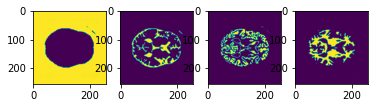

In [15]:
#results using dice coeffient loss
for i_1 in (0,1,2,3):
    plt.subplot(1, 4, i_1 + 1)
    plt.imshow(results[0][:,:,i_1])
plt.show()

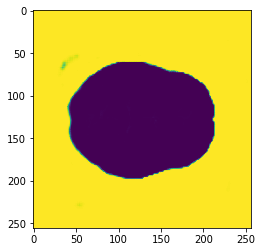

In [16]:
#results using categorical cross entropy
img = tf.keras.preprocessing.image.array_to_img(i)
img
plt.imshow(results[0][:,:,0])

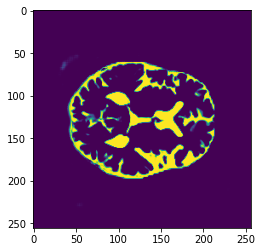

In [17]:
plt.imshow(results[0][:,:,1])

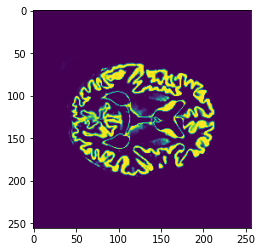

In [18]:
plt.imshow(results[0][:,:,2])

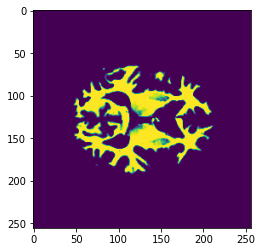

In [19]:
plt.imshow(results[0][:,:,3])